In [1]:
import os
from collections import defaultdict
import numpy as np

log_dir = './logs'
experiment_logs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        parts = filename.split('-')
        method = '-'.join(parts[0:1])
        experiment_name = '-'.join(parts[1:2])
        dataset = '-'.join(parts[2:3])
        if method == "Auncel":
            k = int('-'.join(parts[3:4]))
            error = float(parts[4:5][0][:-4])
            if dataset == "bert":
                nlist = 128
            else:
                nlist = 1024
        else:
            nlist = '-'.join(parts[3:4])
            k = int('-'.join(parts[4:5]))
            if method == "ConANN":
                error = float(parts[5:6][0])
            else:
                error = float(parts[5:6][0][:-4])

        with open(os.path.join(log_dir, filename), 'r') as file:
            experiment_logs[experiment_name][method][dataset][k][error] = [float(line.strip()) for line in file.readlines()]

datasets = [j for j in experiment_logs['efficiency']['ConANN'].keys()]
print(datasets)
# print(experiment_logs['error']['Faiss']['fasttext'])

data = experiment_logs['error']['ConANN']['bert'][100][0.1]
average = np.mean(data)
print(average)

data = experiment_logs['error']['Auncel']['deep10M'][100][0.1]
# print(data)
average = np.mean(data)
print(average)

['gist', 'sift1M', 'deep10M', 'bert', 'fasttext']
0.10546579307860263
0.00292199903


# Empiric FNR vs Alpha value

/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


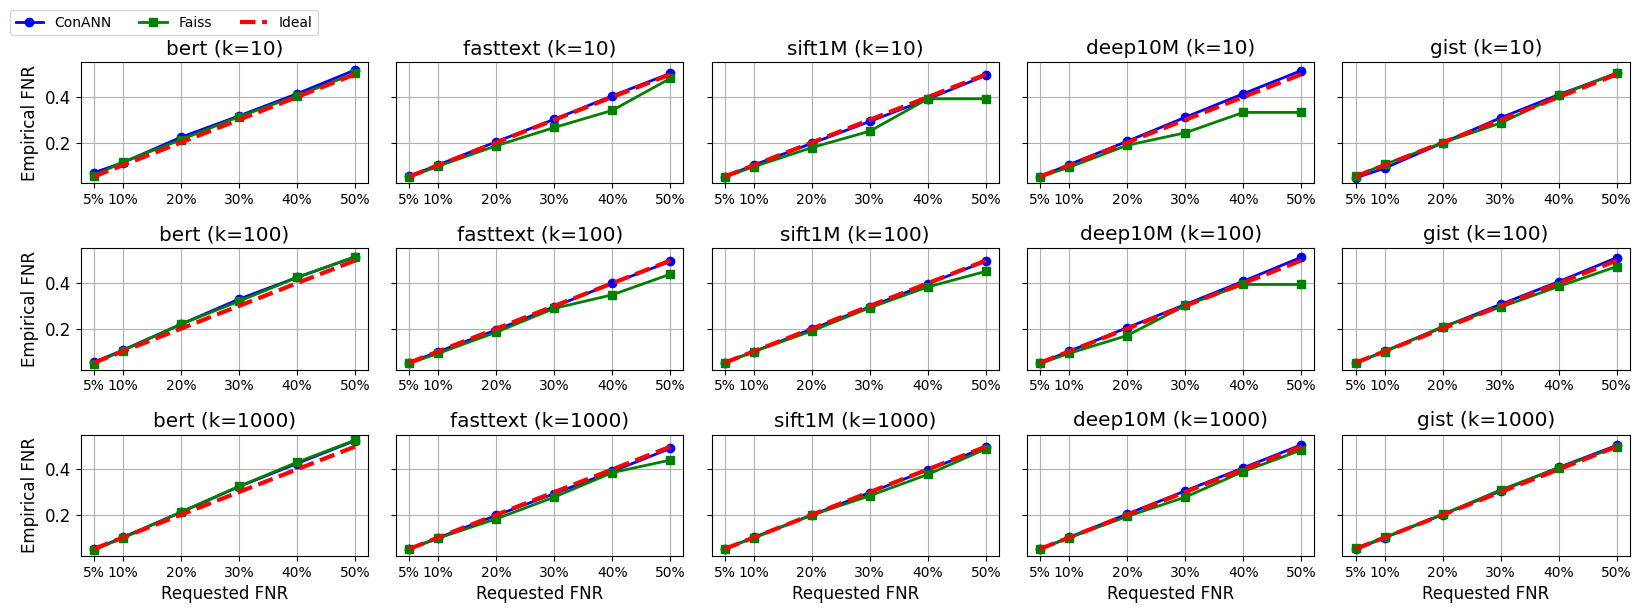

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

experiment_name = 'error'
k_values = [10, 100, 1000]  # List of k values
error_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']
data = {dataset: {k_value: {error: {} for error in error_values} for k_value in k_values} for dataset in target_datasets}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset in target_datasets:
            for k_value in k_values:
                for error_value in error_values:
                    try:
                        values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                        avg_value = np.mean(values)
                        std_value = np.std(values)
                        deviation = abs(avg_value - error_value)
                        if values and len(values) > 0:
                            max_value = np.max(values)
                        else:
                            max_value = None
                        data[dataset][k_value][error_value][method] = {
                            'avg': avg_value,
                            'std': std_value,
                            'max': max_value,
                            'dev': deviation
                        }
                    except KeyError:
                        continue

num_datasets = len(target_datasets)
fig, axs = plt.subplots(len(k_values), num_datasets, figsize=(3.3 * num_datasets, len(k_values) * 2), sharey=True)

if len(k_values) == 1:
    axs = [axs]
if num_datasets == 1:
    axs = [axs]

for k_idx, k_value in enumerate(k_values):
    for i, dataset in enumerate(target_datasets):
        ax = axs[k_idx, i]
        
        conann_avgs = [data[dataset][k_value][error].get('ConANN', {}).get('avg', 0) for error in error_values]
        conann_std = [data[dataset][k_value][error].get('ConANN', {}).get('std', 0) for error in error_values]
        faiss_avgs = [data[dataset][k_value][error].get('Faiss', {}).get('avg', 0) for error in error_values]
        faiss_std = [data[dataset][k_value][error].get('Faiss', {}).get('std', 0) for error in error_values]

        ax.plot(error_values, conann_avgs, label='ConANN', marker='o', linestyle='-', color='b', linewidth=2)
        ax.plot(error_values, faiss_avgs, label='Faiss', marker='s', linestyle='-', color='g', linewidth=2)
        ax.plot(error_values, error_values, color='r', linestyle='--', label='Ideal', linewidth=3)

        ax.set_xticks(error_values)
        ax.set_xticklabels([f'{int(error * 100)}%' for error in error_values], fontsize=10)

        ax.set_title(f'{dataset} (k={k_value})')
        ax.grid(True)

        if k_idx == len(k_values) - 1:
            ax.set_xlabel('Requested FNR')

        if i == 0:
            ax.set_ylabel('Empirical FNR')

handles, labels = axs[0, 4].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize=10, ncol=4, bbox_to_anchor=(0, 1.03))

plt.tight_layout() 
plt.savefig(f'validity_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [16]:
max_devs = {}
for method in ['ConANN', 'Faiss']:
    devs = []
    for dataset in target_datasets:
        for k in k_values:
            for error in error_values:
                entry = data[dataset][k][error].get(method)
                if entry and 'dev' in entry:
                    devs.append(entry['dev'])
    if devs:
        max_devs[method] = max(devs)

print("Max deviations from ideal:", max_devs)

avg_devs = {}
for method in ['ConANN', 'Faiss']:
    devs = []
    for dataset in target_datasets:
        for k in k_values:
            for error in error_values:
                entry = data[dataset][k][error].get(method)
                if entry and 'dev' in entry:
                    devs.append(entry['dev'])
    if devs:
        avg_devs[method] = np.mean(devs)
print("Avg deviations from ideal:", avg_devs)

Max deviations from ideal: {'ConANN': np.float64(0.029927219468704525), 'Faiss': np.float64(0.16737999999999997)}
Avg deviations from ideal: {'ConANN': np.float64(0.006779593226011824), 'Faiss': np.float64(0.01788584218241833)}


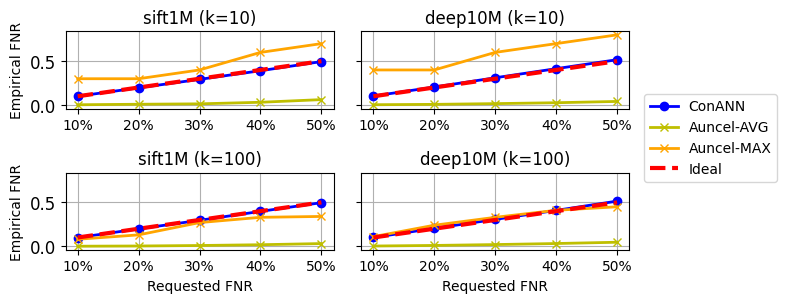

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

experiment_name = 'error'
k_values = [10, 100]  
error_values = [0.1, 0.2, 0.3, 0.4, 0.5]
target_datasets = ['sift1M', 'deep10M']
data = {dataset: {k_value: {error: {} for error in error_values} for k_value in k_values} for dataset in target_datasets}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset in target_datasets:
            for k_value in k_values:  # Iterate over k_values
                for error_value in error_values:
                    try:
                        values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                        avg_value = np.mean(values)
                        std_value = np.std(values)
                        if values and len(values) > 0:
                            max_value = np.max(values)
                        else:
                            max_value = None
                        data[dataset][k_value][error_value][method] = {
                            'avg': avg_value,
                            'std': std_value,
                            'max': max_value,
                        }
                    except KeyError:
                        continue

num_datasets = len(target_datasets)
fig, axs = plt.subplots(len(k_values), num_datasets, figsize=(3.3 * num_datasets, len(k_values) * 1.6), sharey=True)

if len(k_values) == 1:
    axs = [axs]
if num_datasets == 1:
    axs = [axs]

for k_idx, k_value in enumerate(k_values):
    for i, dataset in enumerate(target_datasets):
        ax = axs[k_idx, i]
        
        conann_avgs = [data[dataset][k_value][error].get('ConANN', {}).get('avg', 0) for error in error_values]
        conann_std = [data[dataset][k_value][error].get('ConANN', {}).get('std', 0) for error in error_values]
        auncel_avgs = [data[dataset][k_value][error].get('Auncel', {}).get('avg', 0) for error in error_values]
        auncel_std = [data[dataset][k_value][error].get('Auncel', {}).get('std', 0) for error in error_values]

        auncel_max = [data[dataset][k_value][error].get('Auncel', {}).get('max', 0) for error in error_values]

        ax.plot(error_values, conann_avgs, label='ConANN', marker='o', linestyle='-', color='b', linewidth=2)

        if not (dataset == "bert" or dataset == "fasttext"):
            ax.plot(error_values, auncel_avgs, label='Auncel-AVG', marker='x', linestyle='-', color='y', linewidth=2)
            ax.plot(error_values, auncel_max, label='Auncel-MAX', marker='x', linestyle='-', color='orange', linewidth=2)

        ax.plot(error_values, error_values, color='r', linestyle='--', label='Ideal', linewidth=3)

        ax.set_xticks(error_values)
        ax.set_xticklabels([f'{int(error * 100)}%' for error in error_values], fontsize=10)

        ax.set_title(f'{dataset} (k={k_value})', fontsize=12)
        ax.grid(True)

        if k_idx == len(k_values) - 1:
            ax.set_xlabel('Requested FNR', fontsize=10)

        if i == 0:
            ax.set_ylabel('Empirical FNR', fontsize=10)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10, ncol=1, bbox_to_anchor=(1.2, 0.7))

plt.tight_layout()
plt.savefig(f'validity_auncel.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()